### Импорт библиотек


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns

----

### Чтение данных


In [5]:
df = pd.read_csv('Titanic.csv')

----

### Предпросмотр данных и работа с ними


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


На данном этапе можно убрать следующие данные:

- PassengerID - просто ID пассажира, не может влиять на выживаемость
- Name - уникальное имя пассажира, также не может влиять на его выживаемость
- Embarked - город посадки пассажира, также не может влиять на выживаемость, особенно на больших данных
- Ticket - номер билета пассажира, скорее всего не имеет влияения на выживаемость

In [6]:
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Embarked', axis=1)
df = df.drop('Ticket', axis=1)

#### Работа с NaN

Проверим данные на наличие пропущенных значений.

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687


В качестве результата проверки имеем:

- Cabin - содержит слишком много незаполненных ячеек, попытка заполнения не может быть успешной из-за маленького объема данных

Удалим её для более точной оценки выживаемости:

In [7]:
df = df.drop('Cabin', axis=1)

У нас остается одна колонка не int, переводим:

In [8]:
df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})

----

### Разведочный анализ данных (EDA)


#### Анализ графиков

На графике зависимости цены билета от возраста видим, что есть группа среднего возраста с повышенной стоимостью билета => на основе этого можем предположить, что цена билета зависит от возраста (и наоборот)

Есть группа значений с увеличенной ценой билета возрастом от 15 до 50

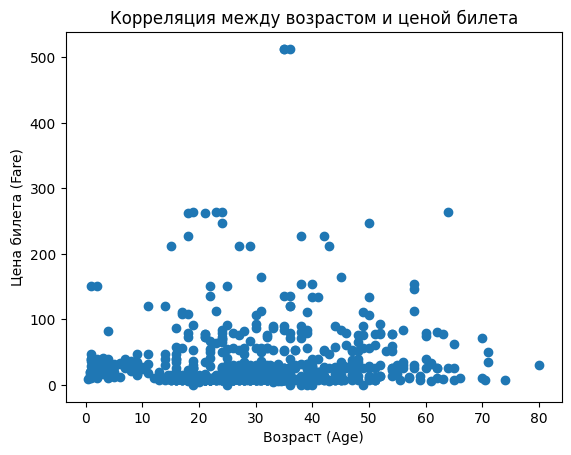

In [11]:
plt.scatter(df['Age'], df['Fare'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Цена билета (Fare)')
plt.title('Корреляция между возрастом и ценой билета')
plt.show()

...
----------

На так называемом ящике с усами видно, что мужчины в целом старше и имеют больше выбросов по возрасте (крайних значений):

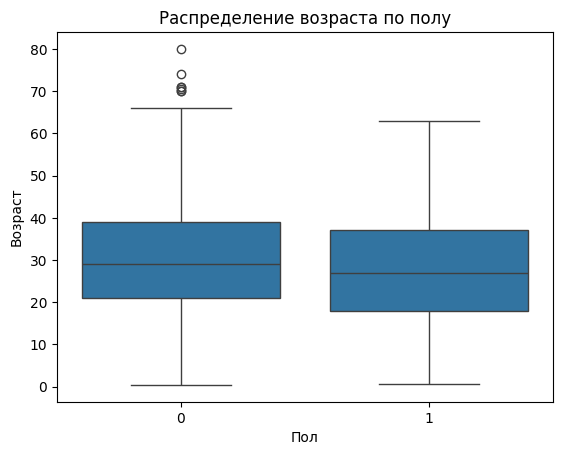

In [12]:
sns.boxplot(x='Sex', y='Age', data=df)
plt.xlabel('Пол')
plt.ylabel('Возраст')
plt.title('Распределение возраста по полу')
plt.show()

...
----------

На графике ниже видно зависимость выживаемости от возраста: у людей среднего возраста выживаемость значительно ниже, чем в группах от 0 до 15 и от 55 до 80 лет, о чем свидетельствует яркий провал в возрастной группе 20 - 50 лет

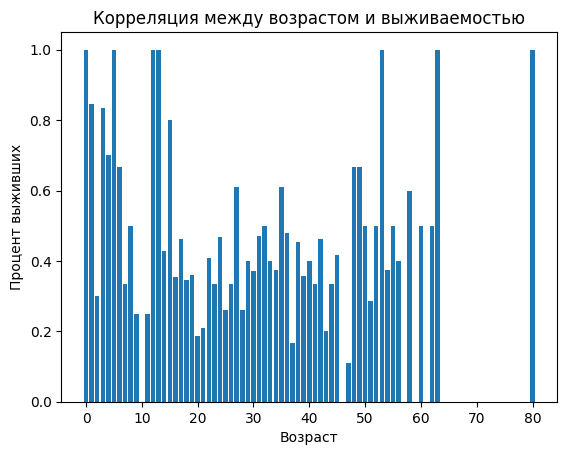

In [13]:
rounded_ages = df['Age'].round()
survival_rates = df.groupby(rounded_ages)['Survived'].mean()
plt.bar(survival_rates.index, survival_rates.values)
plt.xlabel('Возраст')
plt.ylabel('Процент выживших')
plt.title('Корреляция между возрастом и выживаемостью')
plt.show()

...
----------

Главная проблема двух графиков ниже - их интерпретация. Параметр является гибридным, поэтому, например, 1 колонке SibSp может обозначать как супруга, так и брата/сестру. Аналогичная проблема присутствует и в колонке Parch. Еще больше усложняет ситуацию то, что на титанике может быть три поколения одной семьи, или, например, дедушка с внуком, что не будет как либо зачислено в датасете. Поэтому эти колонки отбрасываются для подсчета корреляции возраста.

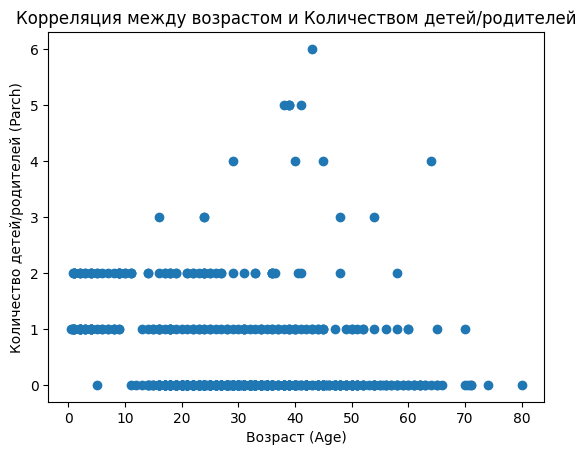

In [14]:
plt.scatter(df['Age'], df['Parch'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество детей/родителей (Parch)')
plt.title('Корреляция между возрастом и Количеством детей/родителей')
plt.show()

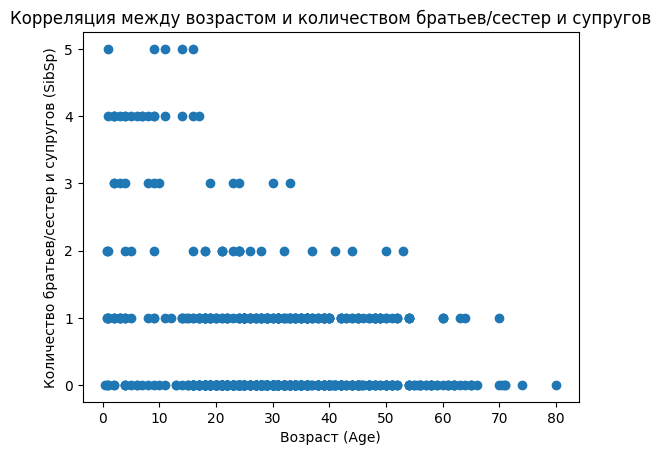

In [15]:
plt.scatter(df['Age'], df['SibSp'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество братьев/сестер и супругов (SibSp)')
plt.title('Корреляция между возрастом и количеством братьев/сестер и супругов')
plt.show()

...
----------

#### Модель К-ближайших соседей

На основе графиков мы можем создать модель К-ближайших соседей. Выстраиваем корреляцию возраста с параметрами класса билета, пола и стоимости билета и делаем предсказание для пустых ячеек.

In [11]:
df_train = df[~df['Age'].isnull()]
features = ['Pclass', 'Sex', 'Fare', 'Survived']
model =  KNeighborsRegressor(n_neighbors=5)
model.fit(df_train[features], df_train['Age'])
df_test = df[df['Age'].isnull()]
predicted_age = model.predict(df_test[features])
df.loc[df['Age'].isnull(), 'Age'] = predicted_age

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0


In [12]:
X = df.drop(columns=['Survived'])
y = df['Survived']

Присутствует дизбаланс классов

In [ ]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


По графику ниже можем заметить сильную корреляцию с колонками Fare, Pclass и сладую корреляцию с Age и Parch. Корреляция с SibSp практически отсутствует.

In [ ]:
df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,0.543351,-0.111891,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.131900,-0.357595,0.083081,0.018443,-0.549500
Sex,0.543351,-0.131900,1.000000,-0.132805,0.114631,0.245489,0.182333
Age,-0.111891,-0.357595,-0.132805,1.000000,-0.202555,-0.177871,0.091416
SibSp,-0.035322,0.083081,0.114631,-0.202555,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,0.245489,-0.177871,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.182333,0.091416,0.159651,0.216225,1.000000


In [13]:
df = df.drop('SibSp', axis=1)

----

### Построение моделей


Теперь у нас есть все данные в таблице, можем строить модели

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [20]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=52
)

...
----------

#### Простая полносвязная сеть

In [21]:
md1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1, 10, "Простая полносвязная сеть", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5688 - loss: 0.9575 - val_accuracy: 0.6567 - val_loss: 0.7245
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6596 - loss: 0.6284 - val_accuracy: 0.6716 - val_loss: 0.6140
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7141 - loss: 0.5667 - val_accuracy: 0.6642 - val_loss: 0.6197
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6712 - loss: 0.5908 - val_accuracy: 0.6716 - val_loss: 0.6166
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6980 - loss: 0.5759 - val_accuracy: 0.6866 - val_loss: 0.5722
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7398 - loss: 0.5416 - val_accuracy: 0.7239 - val_loss: 0.5768
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7200 - loss: 0.5502 - val_accuracy: 0.7239 - val_loss: 0.5565
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7323 - loss: 0.5602 - val_accuracy: 0.7090 - val_loss: 0.5618
Epo

...
----------

#### Сеть с дропаутом

In [22]:
md2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md2, 10, "Сеть с дропаутом", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5420 - loss: 1.7261 - val_accuracy: 0.6269 - val_loss: 1.3713
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6506 - loss: 1.2128 - val_accuracy: 0.6866 - val_loss: 0.9871
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6217 - loss: 0.9287 - val_accuracy: 0.6269 - val_loss: 0.9022
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6583 - loss: 0.8206 - val_accuracy: 0.6940 - val_loss: 0.8228
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6845 - loss: 0.7376 - val_accuracy: 0.6866 - val_loss: 0.7156
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6240 - loss: 0.7273 - val_accuracy: 0.6343 - val_loss: 0.7221
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6608 - loss: 0.7491 - val_accuracy: 0.6343 - val_loss: 0.7666
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6585 - loss: 0.7025 - val_accuracy: 0.7015 - val_loss: 0.6356
Epo

...
----------

#### Сеть с рекуррентным слоем

In [36]:
md3 = keras.Sequential([
    layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
get_metrix_of_model(md3, 10, "Сеть с рекуррентным слоем", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6015 - loss: 0.6588 - val_accuracy: 0.6418 - val_loss: 0.6308
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6273 - loss: 0.6227 - val_accuracy: 0.6418 - val_loss: 0.6228
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6708 - loss: 0.6012 - val_accuracy: 0.6418 - val_loss: 0.6178
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6687 - loss: 0.5929 - val_accuracy: 0.6716 - val_loss: 0.6178
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6897 - loss: 0.5900 - val_accuracy: 0.6642 - val_loss: 0.6058
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6886 - loss: 0.5798 - val_accuracy: 0.6716 - val_loss: 0.6022
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7053 - loss: 0.5616 - val_accuracy: 0.6866 - val_loss: 0.6080
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6729 - loss: 0.5902 - val_accuracy: 0.6791 - val_loss: 0.5950
Epo

...
----------

Лучшая точность у простой полносвязной сети, поэксперементируем с топологией сети:

In [61]:
md1_1 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_1, 10, "128-64-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5847 - loss: 1.6029 - val_accuracy: 0.6716 - val_loss: 0.6533
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6916 - loss: 0.6026 - val_accuracy: 0.6940 - val_loss: 0.5942
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7078 - loss: 0.5734 - val_accuracy: 0.7015 - val_loss: 0.5886
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6810 - loss: 0.5625 - val_accuracy: 0.6269 - val_loss: 0.6065
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6884 - loss: 0.5932 - val_accuracy: 0.6716 - val_loss: 0.5880
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6726 - loss: 0.5587 - val_accuracy: 0.6866 - val_loss: 0.5788
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7384 - loss: 0.5409 - val_accuracy: 0.6716 - val_loss: 0.5721
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7146 - loss: 0.5829 - val_accuracy: 0.7164 - val_loss: 0.6274
Epo

In [60]:
md1_2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2, 10, "64-128-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6112 - loss: 1.0392 - val_accuracy: 0.6716 - val_loss: 0.6243
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 0.6397 - val_accuracy: 0.6791 - val_loss: 0.5793
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6806 - loss: 0.6061 - val_accuracy: 0.6716 - val_loss: 0.5875
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6781 - loss: 0.5933 - val_accuracy: 0.6866 - val_loss: 0.5783
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7178 - loss: 0.5483 - val_accuracy: 0.6940 - val_loss: 0.6042
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6969 - loss: 0.5638 - val_accuracy: 0.7015 - val_loss: 0.5729
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7253 - loss: 0.5574 - val_accuracy: 0.7164 - val_loss: 0.6116
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7326 - loss: 0.5560 - val_accuracy: 0.7015 - val_loss: 0.5693
Epo

In [65]:
md1_3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_3, 10, "32-64-32-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5689 - loss: 0.9400 - val_accuracy: 0.6642 - val_loss: 0.6436
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6962 - loss: 0.5988 - val_accuracy: 0.6866 - val_loss: 0.6177
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7131 - loss: 0.5514 - val_accuracy: 0.6343 - val_loss: 0.6285
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 0.5984 - val_accuracy: 0.6940 - val_loss: 0.6207
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6790 - loss: 0.5859 - val_accuracy: 0.6716 - val_loss: 0.5992
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6902 - loss: 0.5832 - val_accuracy: 0.6418 - val_loss: 0.6489
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7112 - loss: 0.5795 - val_accuracy: 0.6791 - val_loss: 0.5752
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7163 - loss: 0.5671 - val_accuracy: 0.6791 - val_loss: 0.5780
Epo

...
----------

Лучшие метрики показала модель с топологией 64-128-1, можем также посмотреть на данную модель с разным количеством нейронов:

In [67]:
md1_2_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_1, 10, "64-256-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5892 - loss: 0.8617 - val_accuracy: 0.6567 - val_loss: 0.6874
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6533 - loss: 0.6513 - val_accuracy: 0.6567 - val_loss: 0.7868
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6889 - loss: 0.6682 - val_accuracy: 0.6716 - val_loss: 0.6664
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.6357 - val_accuracy: 0.6343 - val_loss: 0.6480
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7162 - loss: 0.5618 - val_accuracy: 0.6567 - val_loss: 0.5900
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6732 - loss: 0.6228 - val_accuracy: 0.6791 - val_loss: 0.7577
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6925 - loss: 0.6651 - val_accuracy: 0.7015 - val_loss: 0.7876
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7061 - loss: 0.6114 - val_accuracy: 0.7239 - val_loss: 0.5641
Epo

In [66]:
md1_2_2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_2, 10, "128-256-1", X_train, y_train, X_test, y_test)

Epoch 1/10


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6024 - loss: 1.2015 - val_accuracy: 0.5597 - val_loss: 0.6635
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6706 - loss: 0.6811 - val_accuracy: 0.4478 - val_loss: 0.7433
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5905 - loss: 0.6627 - val_accuracy: 0.6269 - val_loss: 0.6927
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7239 - loss: 0.5733 - val_accuracy: 0.6940 - val_loss: 0.6077
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6766 - loss: 0.5945 - val_accuracy: 0.6866 - val_loss: 0.6135
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7267 - loss: 0.5711 - val_accuracy: 0.6791 - val_loss: 0.7288
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7354 - loss: 0.5964 - val_accuracy: 0.6940 - val_loss: 0.5956
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7544 - loss: 0.5111 - val_accuracy: 0.7388 - val_loss: 0.6430
Epo

In [ ]:
md1_2_3 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

get_metrix_of_model(md1_2_3, 10, "128-512-1", X_train, y_train, X_test, y_test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6152 - loss: 1.1760 - val_accuracy: 0.5224 - val_loss: 0.8068
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6681 - loss: 0.6549 - val_accuracy: 0.6940 - val_loss: 0.6693
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6807 - loss: 0.6149 - val_accuracy: 0.6493 - val_loss: 0.7445
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6954 - loss: 0.6399 - val_accuracy: 0.6418 - val_loss: 0.7873
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7052 - loss: 0.6050 - val_accuracy: 0.6866 - val_loss: 0.6422
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7371 - loss: 0.5714 - val_accuracy: 0.7388 - val_loss: 0.5343
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7546 - loss: 0.4838 - val_accuracy: 0.7164 - val_loss: 0.5305
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7006 - loss: 0.5997 - val_accuracy: 0.6940 - val_loss: 0.6490
Ep

...
----------

#### Кросс-валидация

Лучшие метрики показала модель с 128-512-1 нейроном


In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

kFold = StratifiedKFold(n_splits=6, shuffle=True, random_state=52)

f1s = []
reports = []
matrixes = []

for train_index, test_index in kFold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        epochs=10,
        verbose=0
    )

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype(int)

    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    report = classification_report(y_test, y_pred)
    reports.append(report)
    matrix = confusion_matrix(y_test, y_pred)
    matrixes.append(matrix)

    print(f'Фолд:')
    print(f'Точность: {accuracy}')
    print(f'F1-мера: {f1}')
    print(f'Classification Report:\n{report}')
    print(f'Confusion Matrix:\n{matrix}')

print('\nСредние значения по всем фолдам:')
print(f'Средняя F1-мера: {sum(f1s) / len(f1s)}')

C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Фолд:
Точность: 0.7718120813369751
F1-мера: 0.7536231884057971
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.68      0.79        92
           1       0.64      0.91      0.75        57

    accuracy                           0.77       149
   macro avg       0.78      0.80      0.77       149
weighted avg       0.82      0.77      0.77       149

Confusion Matrix:
[[63 29]
 [ 5 52]]


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Фолд:
Точность: 0.7315436005592346
F1-мера: 0.47368421052631576
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.99      0.82        92
           1       0.95      0.32      0.47        57

    accuracy                           0.73       149
   macro avg       0.82      0.65      0.65       149
weighted avg       0.79      0.73      0.69       149

Confusion Matrix:
[[91  1]
 [39 18]]


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Фолд:
Точность: 0.6778523325920105
F1-мера: 0.45454545454545453
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.88      0.77        92
           1       0.65      0.35      0.45        57

    accuracy                           0.68       149
   macro avg       0.67      0.62      0.61       149
weighted avg       0.67      0.68      0.65       149

Confusion Matrix:
[[81 11]
 [37 20]]


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Фолд:
Точность: 0.6351351141929626
F1-мера: 0.1
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        91
           1       1.00      0.05      0.10        57

    accuracy                           0.64       148
   macro avg       0.81      0.53      0.44       148
weighted avg       0.77      0.64      0.51       148

Confusion Matrix:
[[91  0]
 [54  3]]


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Фолд:
Точность: 0.7297297120094299
F1-мера: 0.5238095238095238
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81        91
           1       0.81      0.39      0.52        57

    accuracy                           0.73       148
   macro avg       0.76      0.67      0.67       148
weighted avg       0.75      0.73      0.70       148

Confusion Matrix:
[[86  5]
 [35 22]]


C:\Users\chern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Фолд:
Точность: 0.662162184715271
F1-мера: 0.375
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.91      0.77        91
           1       0.65      0.26      0.38        57

    accuracy                           0.66       148
   macro avg       0.66      0.59      0.57       148
weighted avg       0.66      0.66      0.62       148

Confusion Matrix:
[[83  8]
 [42 15]]

Средние значения по всем фолдам:
Средняя F1-мера: 0.44677706288118185


...
----------

#### Результаты

Кросс валидация показала противоречивые результаты с точки зрения эффективности модели, на некоторых фолдах метрики были неплохими, на других они были не самыми лучшими.
- 1 Фолд: Модель предсказала 63 погибшего верно, отнеся 29 к неправильному классу. Также модель предсказала 5 выживших верно и отнесла 52 к неправильному классу
- 2 Фолд: Модель предсказала 91 погибших верно, отнеся 1 к неправильному классу. Также модель предсказала 39 выживших верно и отнесла 18 к неправильному классу
- 3 Фолд: Модель предсказала 81 погибших верно, отнеся 11 к неправильному классу. Также модель предсказала 37 выжившего верно и отнесла 20 к неправильному классу
- 4 Фолд: Модель предсказала 91 погибших верно, отнеся 0 к неправильному классу. Также модель предсказала 54 выжившего верно и отнесла 3 к неправильному классу
- 5 Фолд: Модель предсказала 86 погибших верно, отнеся 5 к неправильному классу. Также модель предсказала 35 выжившего верно и отнесла 22 к неправильному классу
- 6 Фолд: Модель предсказала 83 погибших верно, отнеся 8 к неправильному классу. Также модель предсказала 42 выжившего верно и отнесла 15 к неправильному классу

----

### Итоги


<b>Вывод:</b>    Был проделан комплексный обзор даты с дозаполнением пустых ячеек методом K ближайших соседей. Было проведено 9 экспериментов с целью найти наиболее эффективную модель. Модель, показавшая наилучший результат, была подвергнута тестированию на шести фолдах, которое показало её уязвимость перед другими частями датасета. Главной сложностью работы можно наблюдать маленький объем датасета, что делает любые попытки точного предсказания труднореализуемыми из-за флуктуций в дате, которые не невелируются ее объемом.